# NLP and dimensionality reduction

@CapeTownFreeway tweets from the entire year of 2017 are provided in the capetownfreeway.csv file included with this training document. We import this csv file and perform some pre-processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

In [3]:
df = pd.read_csv('capetownfreeway_2017.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,favorite_count,source,text,in_reply_to_screen_name,is_retweet,created_at,retweet_count,id_str
0,0,Twitter Web Client,Update: Stationary Vehicle: N7 northbound befo...,NaN,False,Wed Jan 11 14:37:46 +0000 2017,1,819191575490297856
1,0,Twitter Web Client,"Crash: N2 outbound after Raapenberg, right lan...",NaN,False,Thu Jan 26 13:54:41 +0000 2017,1,824616552515395586
2,0,Twitter Web Client,Update: Congestion N2 Inbound at M3 Southbound...,NaN,False,Fri Jan 27 13:15:22 +0000 2017,0,824969046705725445
3,0,Twitter Web Client,Update: Stationary vehicle: N1 Outbound at Pla...,NaN,False,Wed Jan 25 12:36:11 +0000 2017,0,824234408358068225
4,0,Twitter Web Client,"Veldfire: N2 Inbound before Raapenberg, Left L...",NaN,False,Mon Jan 16 03:12:10 +0000 2017,1,820830979468181504


A few of these columns will not be useful to us going forward, so we will drop them.

In [5]:
df.drop(['source', 'in_reply_to_screen_name', 'is_retweet'],
        axis=1, inplace=True)

In [6]:
df.shape

(24158, 5)

In [7]:
df.head()

,favorite_count,text,created_at,retweet_count,id_str
0,0,Update: Stationary Vehicle: N7 northbound befo...,Wed Jan 11 14:37:46 +0000 2017,1,819191575490297856
1,0,"Crash: N2 outbound after Raapenberg, right lan...",Thu Jan 26 13:54:41 +0000 2017,1,824616552515395586
2,0,Update: Congestion N2 Inbound at M3 Southbound...,Fri Jan 27 13:15:22 +0000 2017,0,824969046705725445
3,0,Update: Stationary vehicle: N1 Outbound at Pla...,Wed Jan 25 12:36:11 +0000 2017,0,824234408358068225
4,0,"Veldfire: N2 Inbound before Raapenberg, Left L...",Mon Jan 16 03:12:10 +0000 2017,1,820830979468181504


We use the **clean_tweet** function to remove any url's and any campaign-specific keywords that are frequently repeated in tweets. These tend to create a large amount of noise in the data, which will make the clustering process difficult later on.

In [8]:
def clean_tweet(tweet):
    no_link_loc = re.sub(r"http\S+", "", tweet)
    no_num_loc = no_link_loc.lower()
    for c in ['inbound','outbound','after','before','update','after','animals','roadworks',':',',',
              '#','@','savewater', 'boozefreeroads','speedkillsfacts','saferoadsforall', 'sharetheroad',
              'alwaysbuckleup', 'boozefreeroad','alwaysbuckleup','savekidslives','.','walksafe']:
        no_num_loc = no_num_loc.replace(c, '')
        
    no_num_loc = no_num_loc.split(',')[0]
    try:
        return no_num_loc
    except:
        pass

In [9]:
df['clean_tweet'] = df['text'].apply(clean_tweet)

In [10]:
df.head()

,favorite_count,text,created_at,retweet_count,id_str,clean_tweet
0,0,Update: Stationary Vehicle: N7 northbound befo...,Wed Jan 11 14:37:46 +0000 2017,1,819191575490297856,stationary vehicle n7 northbound bosmansdam ...
1,0,"Crash: N2 outbound after Raapenberg, right lan...",Thu Jan 26 13:54:41 +0000 2017,1,824616552515395586,crash n2 raapenberg right lane closed expect...
2,0,Update: Congestion N2 Inbound at M3 Southbound...,Fri Jan 27 13:15:22 +0000 2017,0,824969046705725445,congestion n2 at m3 southbound ramp is clear...
3,0,Update: Stationary vehicle: N1 Outbound at Pla...,Wed Jan 25 12:36:11 +0000 2017,0,824234408358068225,stationary vehicle n1 at plattekloof left la...
4,0,"Veldfire: N2 Inbound before Raapenberg, Left L...",Mon Jan 16 03:12:10 +0000 2017,1,820830979468181504,veldfire n2 raapenberg left lane closed driv...


Import some NLP and visualisation packages

In [11]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter

In [12]:
words = []
for i in df.clean_tweet:
    words.extend(word_tokenize(i))

To see the effect of cleaning our tweets, we quickly revisit our wordcloud illustration from Tutorial 1. 

In [13]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(frequencies = Counter(words))

(-0.5, 799.5, 399.5, -0.5)

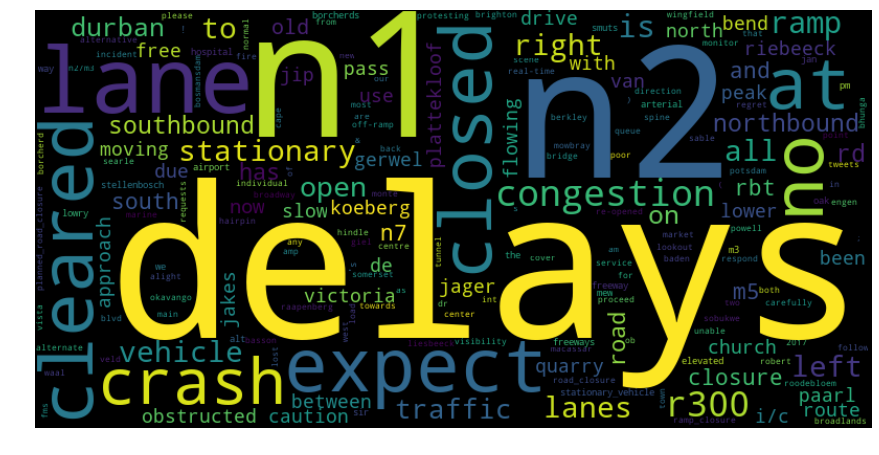

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

As you can see the ratio of 'delays' to 'cleared' is a clear eye-sore for the traffic situation in Cape Town, with clear dominance from the N1 and N2 motorways into the city. 

# Feature selection and extraction to reduce dimensionality 

Feature selection is one method that can be used to reduce dimensions. It involves only considering a subset of the original features of the data. While feature selection is efficient, it is very much all-or-nothing since variables are either kept or removed. There is always the risk that in some instances removed variables may be useful, while kept variables may be redundant. Feature extraction, on the other hand, uses features that are created based on the original features of the dataset. We are going to consider 4 main kinds of feature selection/extraction techniques:

## 1. Term-frequency inverse-document frequency (tf–idf)
**Term frequency** measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (a.k.a. the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

<i>(This is nothing more than the relative frequency of each term in a document)</i>

**Inverse document frequency** measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones, by computing the following: 

IDF(t) = ln(Total number of documents / Number of documents with term t in it).


**An example**
> Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as ln(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

More information can be found here: http://www.ultravioletanalytics.com/2016/11/18/tf-idf-basics-with-pandas-scikit-learn/

### tf–idf in Python
Luckily for us, there is a handy sklearn package called TfidfVectorizer that we can use to choose the number of features we want to keep!

In [15]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=50, stop_words='english')

In [16]:
X = vectorizer.fit_transform(df.clean_tweet).toarray()

The tf-idf vectorizer creates a feature set of length 50, with the most frequently used words in the tweets we provided. It takes care of English stopwords such as 'in', 'on', 'the' etc., which carry little to no meaning in terms of the content of the tweet, and helps us to remove a large amount of noise.

In [17]:
vocab = vectorizer.get_feature_names()

We view the 50 most "important" words

In [18]:
print(vocab)

['church', 'cleared', 'closed', 'closure', 'congestion', 'crash', 'delays', 'drive', 'durban', 'expect', 'flowing', 'free', 'jip', 'koeberg', 'lane', 'lanes', 'left', 'lower', 'm3', 'm5', 'moving', 'n1', 'n2', 'n7', 'north', 'northbound', 'obstructed', 'old', 'open', 'paarl', 'peak', 'plattekloof', 'quarry', 'r300', 'ramp', 'rbt', 'rd', 'riebeeck', 'right', 'road', 'route', 'slow', 'south', 'southbound', 'stationary', 'traffic', 'use', 'van', 'vehicle', 'victoria']


In [19]:
X = pd.DataFrame(X, columns=vocab)

In [20]:
X.head()

,church,cleared,closed,closure,congestion,crash,delays,drive,durban,expect,...,route,slow,south,southbound,stationary,traffic,use,van,vehicle,victoria
0,0.0,0.319054,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.430988,0.0,0.0,0.0,0.425971,0.0
1,0.0,0.000000,0.388721,0.0,0.000000,0.398404,0.263024,0.000000,0.0,0.373899,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.297219,0.000000,0.0,0.336789,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.472128,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.179478,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.346659,0.0,0.0,0.0,0.342623,0.0
4,0.0,0.000000,0.357599,0.0,0.000000,0.000000,0.000000,0.676968,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [21]:
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 24158, n_features: 50


So we are now at a stage where we have tf-idf vectors for each tweet, constructed from the 50 most popular words in the corpus.

## 2. Principal component analysis (PCA)

In [21]:
from time import time
from sklearn import preprocessing, manifold, decomposition

In [22]:
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2)

print("Computing PCA projection")
t0 = time()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
t1 = time()

Computing PCA projection


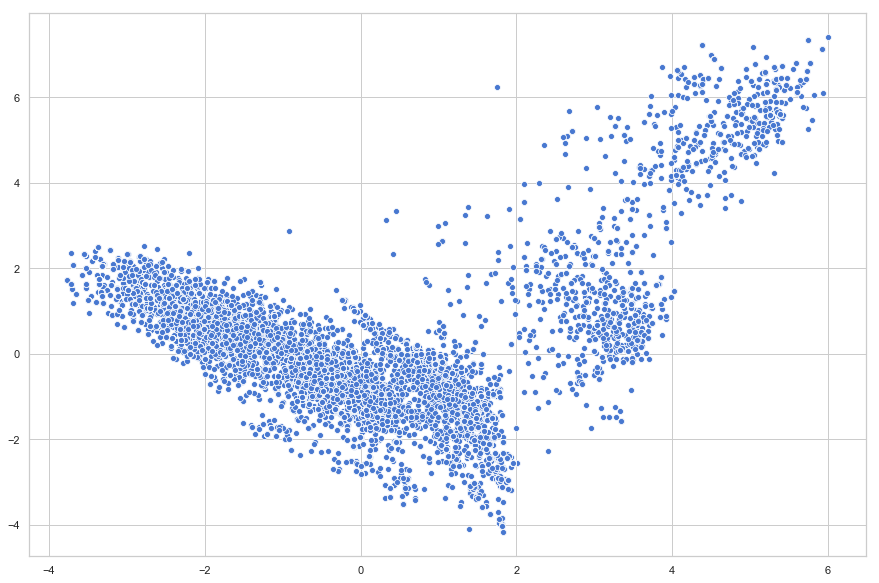

The first two principal components explain 15.0 % of the variance in the data


In [23]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.show()
print("The first two principal components explain " + 
      str(np.round(sum(pca.explained_variance_ratio_[:2]),2)*100) + " % of the variance in the data")

### Interactive data visualization with PlotLy

In [49]:
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [32]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['text'] = df['clean_tweet']

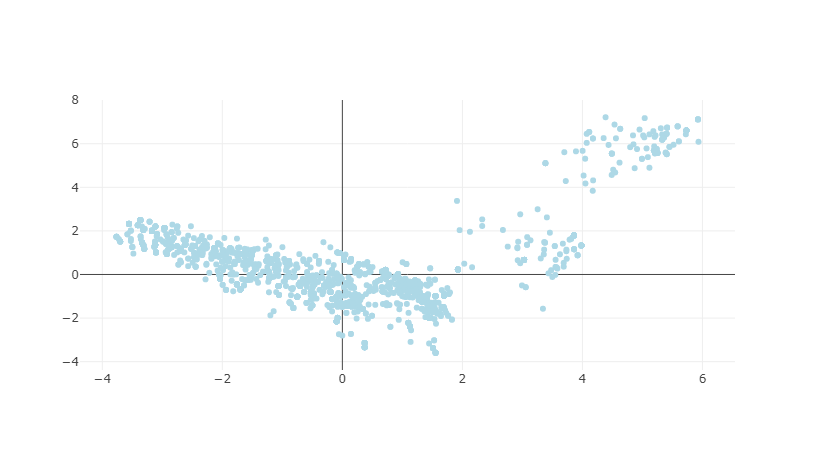

In [53]:
data = [
    go.Scatter(
        x = pca_df.iloc[:2000,0].values,
        y = pca_df.iloc[:2000,1].values,
        text = pca_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

## 3. Multidimensional scaling (MDS)

In [55]:
from sklearn.manifold import MDS
print("Computing MDS embedding")
mds = manifold.MDS(n_components=2, 
                   n_init=2, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
t0 = time()
X_mds = mds.fit_transform(X.iloc[:2000,:])
t1 = time()
print("Done. Stress: %f" % mds.stress_)

Computing MDS embedding
Done. Stress: 454048.166515


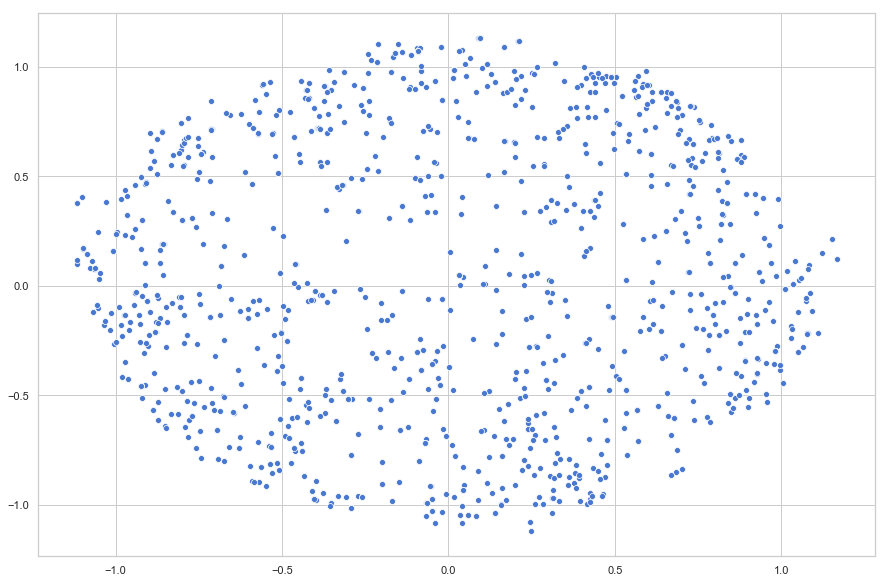

In [56]:
ax = sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1])
plt.show()

There are two important things we note about an MDS scatter plot:

    - The axes themselves are meaningless
    - The orientation of the picture is arbitrary. 
    
The important thing is the proximity of the points. Since this is a lower-dimensional representation of 'similarity' between points in the higher-dimensional space, it is a useful starting point for clustering and other techniques that look to group points together that share similar characteristics.

In [57]:
mds_df = pd.DataFrame(X_mds, columns=['D1', 'D2'])
mds_df['text'] = df['clean_tweet']

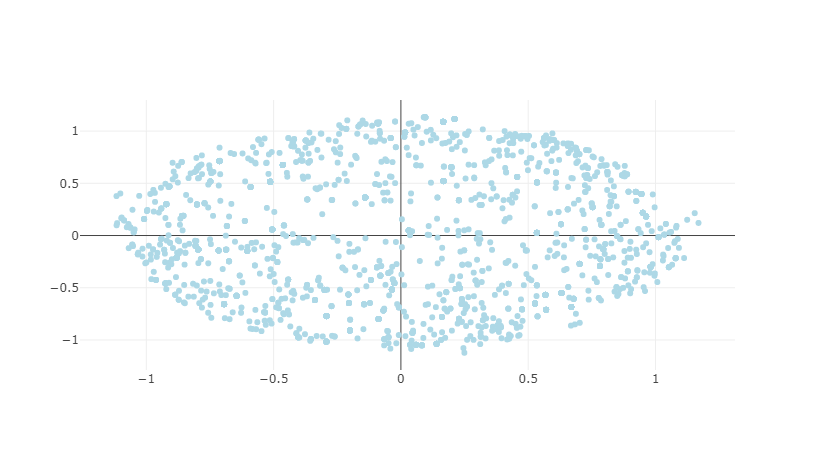

In [58]:
data = [
    go.Scatter(
        x = mds_df.iloc[:2000,0].values,
        y = mds_df.iloc[:2000,1].values,
        text = mds_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

## 4. t-distributed Stochastic Neighbor Embedding (t-SNE)

In [59]:
from sklearn.manifold import TSNE

In [60]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(X.iloc[:5000,:])
t1 = time()

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.032s...
[t-SNE] Computed neighbors for 5000 samples in 1.707s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.246574
[t-SNE] KL divergence after 1000 iterations: 0.386010


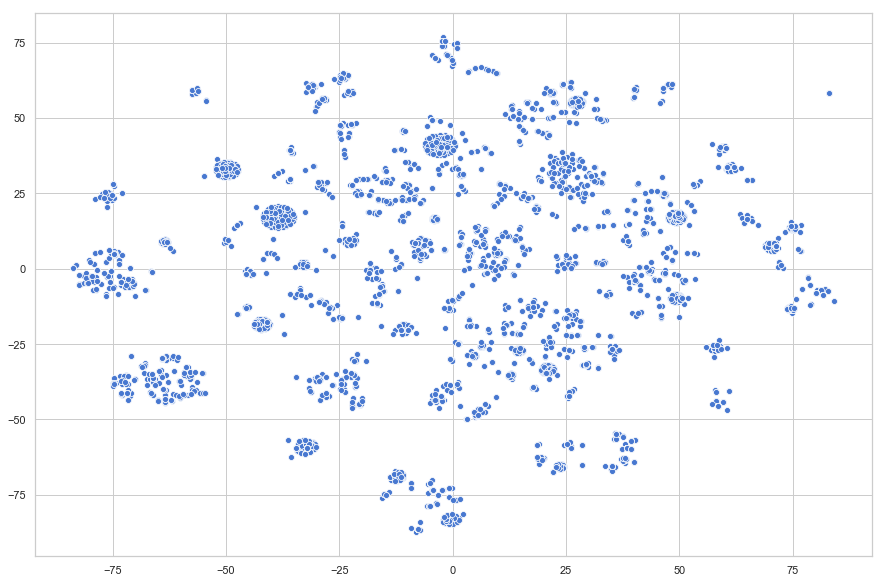

In [61]:
ax = sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1])
plt.show()

The same comments regarding orientation and values also apply to T-SNE. It seems that there are already some well-formed clusters in the above representation suggesting that further investigation needs to be done on the nature of these associations.

In [62]:
tsne_df = pd.DataFrame(X_tsne, columns=['D1', 'D2'])
tsne_df['text'] = df['clean_tweet']

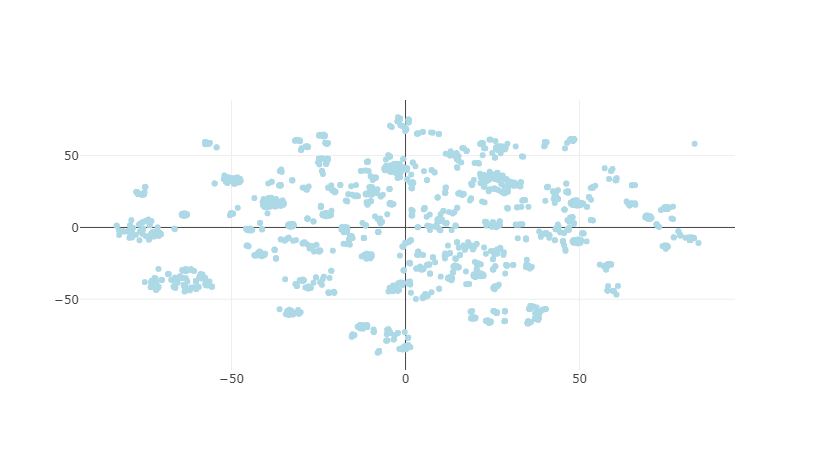

In [63]:
data = [
    go.Scatter(
        x = tsne_df.iloc[:2000,0].values,
        y = tsne_df.iloc[:2000,1].values,
        text = tsne_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")